In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
raw_data = pd.read_csv('tempos.csv')
data = raw_data[raw_data['Deslocado'] == False].copy()

for row in data.index.values:
    try:
        t1 = data.at[row, 'Tempo']
        t2 = data.at[row + 1, 'Tempo']
        data.at[row, 'Tempo'] = ((t1 + t2)/2)
        data = data.drop(row + 1)
        pass
    except:
        continue
    
data = pd.concat([data, raw_data[raw_data['Deslocado'] == True]])

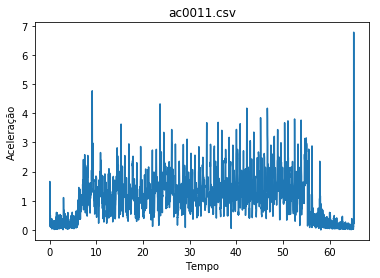

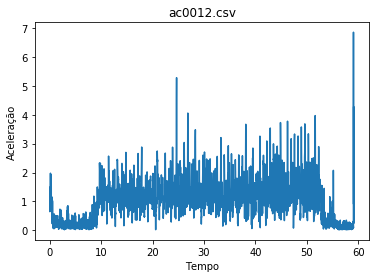

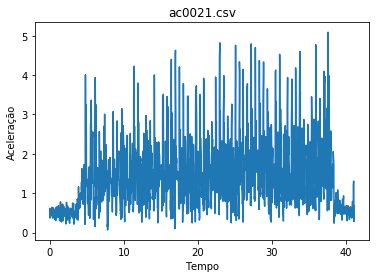

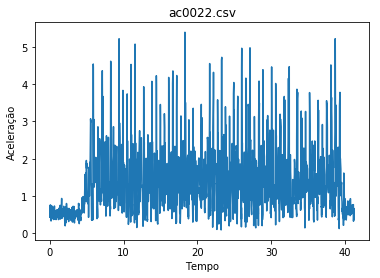

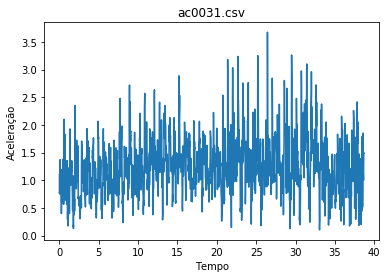

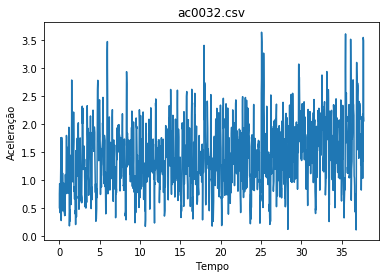

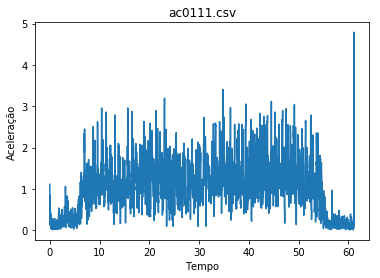

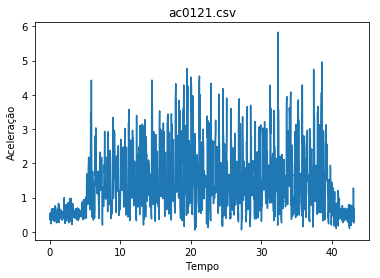

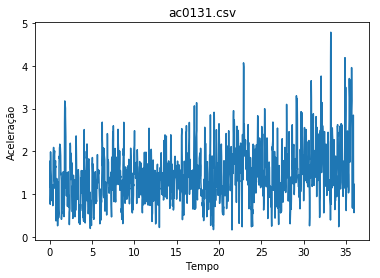

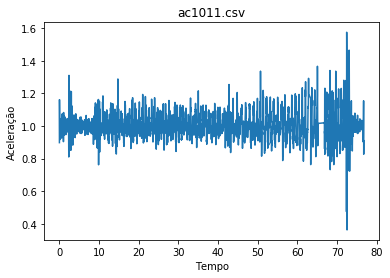

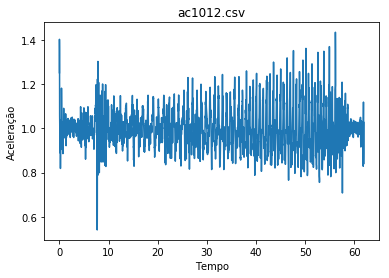

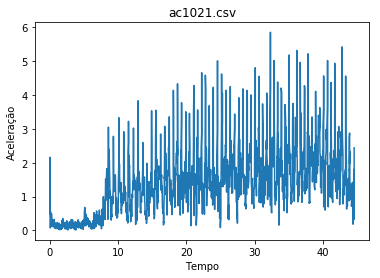

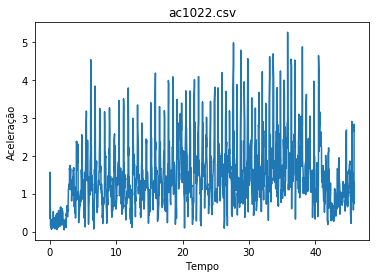

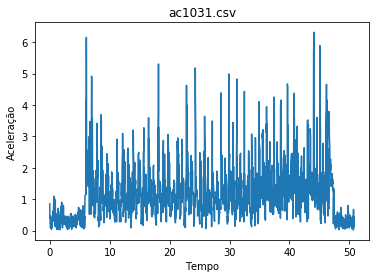

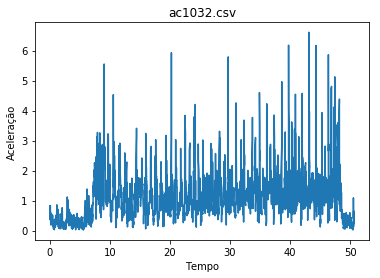

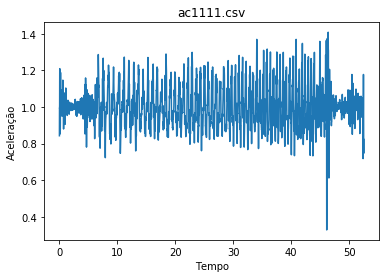

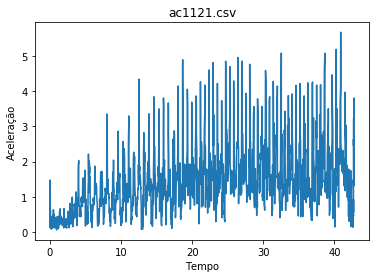

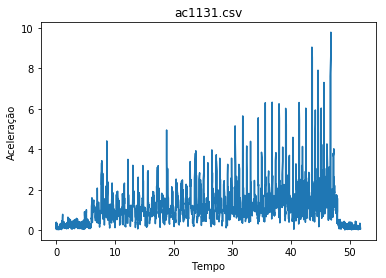

In [6]:
"""
1011
1012
1111
"""

aux = [0, 1]
pessoas = [1, 2, 3]
travessias = [1, 2]

for m in aux:
    for d in aux:
        for p in pessoas:
            for t in travessias:
                
                if d == 1 and t == 2:
                    continue
                
                filename = 'ac' + str(m) + str(d) + str(p) + str(t) + '.csv'
                data = pd.read_csv(filename)
                
                plt.title(filename)
                plt.xlabel('Tempo')
                plt.ylabel('Aceleração')
                plt.plot('time', 'aT', data = data)
                plt.show()